# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [255]:
# # Here is a helping code that will download and unzip the dataset for you.
# # Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,GRU,SimpleRNN

In [257]:
df=pd.read_csv("Traffic Data.csv")

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [258]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [259]:
#parse date
df["date_time"]=pd.to_datetime(df["date_time"])

In [260]:
#sort by date
df.sort_values(by="date_time",inplace=True)

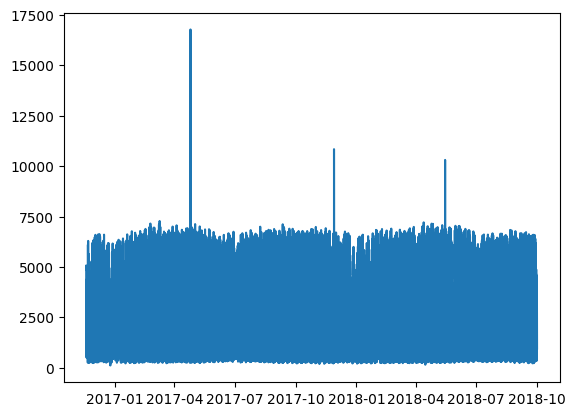

In [261]:
#plot traffic and date

plt.plot(df["date_time"],df["traffic_volume"])

<Axes: ylabel='traffic_volume'>

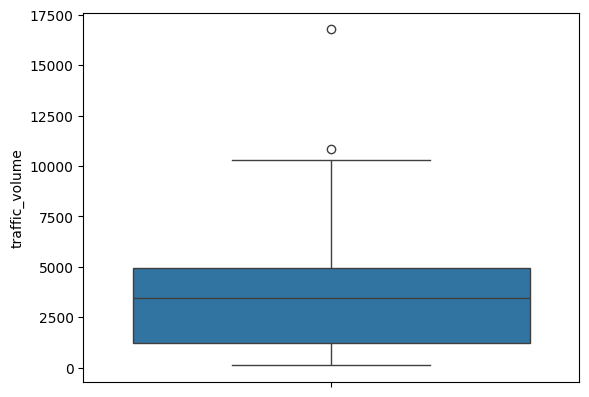

In [262]:
#box plot to show outliers
sns.boxplot(df["traffic_volume"])

In [263]:
#remove outliers
df=df[df["traffic_volume"]<7500]

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [264]:
df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [265]:
df.duplicated().sum()

12

In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19977 entries, 7745 to 3795
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19977 non-null  float64       
 1   temp                 19977 non-null  float64       
 2   rain_1h              19977 non-null  float64       
 3   snow_1h              19977 non-null  float64       
 4   clouds_all           19977 non-null  int64         
 5   weather_main         19977 non-null  object        
 6   weather_description  19977 non-null  object        
 7   date_time            19977 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.4+ MB


In [267]:
#date and time could be duplicated
df["date_time"].duplicated().sum()

3721

In [268]:
#remove duplicated date and time
df=df[~df["date_time"].duplicated()]

In [269]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00
14066,4328.0,273.62,0.0,0.0,90,Snow,heavy snow,2016-11-18 17:00:00
2646,3486.0,273.59,0.0,0.0,90,Snow,heavy snow,2016-11-18 18:00:00
3684,2524.0,273.58,0.0,0.0,90,Snow,light snow,2016-11-18 19:00:00


In [270]:
df["date_time"].duplicated().sum()

0

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [271]:
df["prev_traffic_volume"]=df["traffic_volume"].shift(1)

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [272]:
df=df.set_index("date_time")

In [273]:
#split data to around 80% train and 20% test
train=df.loc[:"20180201"]["traffic_volume"].reset_index()["traffic_volume"].to_numpy()
test=df.loc["20180102":]["traffic_volume"].reset_index()["traffic_volume"].to_numpy()

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [274]:
#scale the data
m=MinMaxScaler()
m.fit(train.reshape(-1,1))
train=m.transform(train.reshape(-1,1))
test=m.transform(test.reshape(-1,1))

In [275]:
#making the time seris as sequence of 6
def make_seq(seq_len,data):
  x=[]
  y=[]
  for i in range(len(data)-seq_len):
    x.append(data[i:seq_len+i])
    y.append(data[seq_len+i])
  return np.array(x),np.array(y)


seq=6
x_train,y_train=make_seq(seq,train)

x_test,y_test=make_seq(seq,test)

In [276]:
x_train.shape

(10488, 6, 1)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [277]:
#buliding lstm

model=tf.keras.models.Sequential()

model.add(LSTM(50,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 6, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [278]:
model.compile("adam","mse")

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [279]:
model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0730 - val_loss: 0.0135
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0104 - val_loss: 0.0053
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 9/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 10/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0039 - val_loss: 0.0034


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [280]:
pred=model.predict(x_test)

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

mean suared error for test is : 0.0033706336856733172


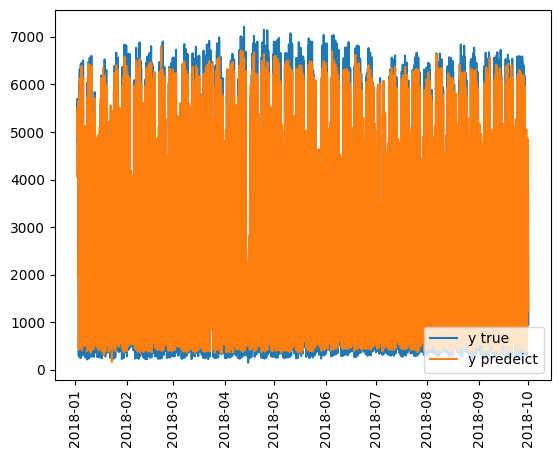

In [281]:
print("mean suared error for test is :", mean_squared_error(pred,y_test))

plt.plot(df.loc["20180102":].index[seq:],m.inverse_transform(y_test),label="y true")
plt.plot(df.loc["20180102":].index[seq:],m.inverse_transform(pred),label="y predeict")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [282]:
#buliding gru

model_gru=tf.keras.models.Sequential()

model_gru.add(GRU(50,input_shape=(x_train.shape[1],1),return_sequences=True))
model_gru.add(GRU(50))
model_gru.add(Dense(1))

model_gru.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 6, 50)               │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [283]:
model_gru.compile("adam","mse")

In [284]:
model_gru.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0400 - val_loss: 0.0064
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0071 - val_loss: 0.0050
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 9/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 10/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0045 - val_loss: 0.0035


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [285]:
pred_gru=model_gru.predict(x_test)

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

mean suared error for test is : 0.0034825260419981355


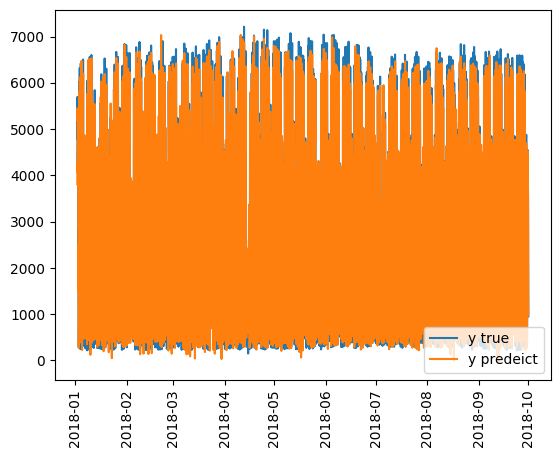

In [286]:
print("mean suared error for test is :", mean_squared_error(pred_gru,y_test))

plt.plot(df.loc["20180102":].index[seq:],m.inverse_transform(y_test),label="y true")
plt.plot(df.loc["20180102":].index[seq:],m.inverse_transform(pred_gru),label="y predeict")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:


## Project Questions:

1. **Data Preprocessing**:
min max normalization is good for time seris forecasting , there was some missing data but after deleting the outliers it was removed.

There was duplicated in the dates so i removed it .


2. **Feature Engineering**: was not used


3. **Model Architecture**: best time series forecastin models are GRU and LSTM.

To pervent overfitting i used simple model



4. **Training Process**: for optimizer i chose adam because it is the best for deep learning

batch size could make a bit diffrent so i tried 32 and it worked fine for number of epochs i chose 10 and it worked fine

5. **Loss Function and Metrics**: for loss function i chose Mean Suared Error, it is also used for the metric, it is good enough for time series forecasting


6. **Model Tuning (If Done)**: tuning was not performed since there was not overfiting or under fiting



7. **Overfitting and Underfitting**: there was not overfiting or under fiting since the mean suared error is low

8. **Future Improvements**: None